In [1]:
import pandas as pd

# openpyxl for xlsx files
df = pd.read_excel("./Data_Ass5.xlsx", engine="openpyxl")
meta = pd.read_excel("./dataset_meta.xlsx", engine="openpyxl")

#print(df.head())
#print(df.columns)

In [2]:
# finding out the number of non-NaN values each Q-column has, to choose 5 values for analysis
q_columns = [col for col in df.columns if col.startswith('Q') and df[col].dtype in ['int64', 'float64']]
df[q_columns].isna().sum().sort_values()

Q123          72
Q2.2         162
Q141         162
Q142         162
Q144         162
Q145         162
Q163_4      5109
Q161_4      5109
Q161_4_1    5259
Q165_4_1    5259
Q110_4      5280
Q165_4      5280
Q155_6      6354
Q154_6      6354
Q107        6354
Q156_6      6354
Q152_6      6354
dtype: int64

##### We can't use these values for analysis

In [3]:
df['district_code'] = df['Q123'].astype(str).str[:2]
district_map = {
    '14':'Akuapim South',
    '25':'Akuapim North',
    '36':'Asikuma Odoben Brakwa',
    '47':'Gomoa West',
    '58':'Agona East',
    '69':'Mfantsiman District'
}
df['district_name'] = df['district_code'].map(district_map)

# Selected variables
selected_cols = ['treatment', 'district_name', 'Duration (in seconds)', 'E1', 'E2', 'E3', 'E5']

# Preparation: droping rows with missing values in analysis variables
df_subset = df.dropna(subset=['Duration (in seconds)', 'E1', 'E2', 'E3', 'E5'])

# Preparation: converting E1–E5 to numeric
df_subset[['E1', 'E2', 'E3', 'E5']] = df_subset[['E1', 'E2', 'E3', 'E5']].apply(pd.to_numeric, errors='coerce')

# Simple descriptive statistics
print(df_subset[['Duration (in seconds)', 'E1', 'E2','E3','E5']].describe())

# separate counts for treatment and district
print("\nTreatment counts:\n", df['treatment'].value_counts(dropna=False))
print("\nDistrict counts:\n", df['district_name'].value_counts(dropna=False))


       Duration (in seconds)           E1           E2           E3  \
count            6282.000000  6271.000000  6271.000000  6280.000000   
mean              447.163801    10.497528    10.554776     2.934236   
std               413.161328     5.837809     6.705504     2.148339   
min                36.000000     0.000000     1.000000     0.000000   
25%               272.000000     5.000000     5.000000     2.000000   
50%               364.000000    11.000000    11.000000     3.000000   
75%               513.000000    15.000000    15.000000     3.000000   
max             13132.000000    98.000000   202.000000   113.000000   

                E5  
count  6282.000000  
mean      2.252149  
std       1.993485  
min       1.000000  
25%       1.000000  
50%       2.000000  
75%       3.000000  
max      93.000000  

Treatment counts:
 treatment1    2758
treatment3    1245
treatment4    1095
treatment2    1074
NaN            182
Name: treatment, dtype: int64

District counts:
 NaN    

/opt/conda/lib/python3.8/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


treatment – Shows which treatment group the person was in (like treatment1, treatment2, etc.). Its used to compare answers between groups.

district_name – This tells us which district the person is from. We got it by taking the first two numbers from another column (Q123).

Duration (in seconds) – This helps us understand, how long the person took to finish the survey.

E1, E2, E3, E5 – Numeric survey responses, likely on a Likert-type scale. Cleaned and converted to numeric for analysis. 

In [4]:
import folium
from folium.plugins import MarkerCluster

# droping NaN's, leaving only valid coordinates and treatment
map_df = df[['LocationLatitude','LocationLongitude','treatment','district_name']].dropna()

# base map over southern Ghana (visual style = CartoDB positron)
m = folium.Map( location=[5.5, -0.5], zoom_start= 8, tiles = 'CartoDB positron')

# marker cluster for better UX
marker_cluster = MarkerCluster().add_to(m)

# adding participants to the map
for _, row in map_df.iterrows():
    folium.CircleMarker(
        location=[row['LocationLatitude'], row['LocationLongitude']],
        radius=4,
        popup=f"Treatment: {row['treatment']}<br>District: {row['district_name']}",
        color=(
            'blue' if row['treatment'] == 'treatment1' else
            'green' if row['treatment'] == 'treatment2' else
            'red' if row['treatment'] == 'treatment3' else
            'orange'
        ),
        fill=True,
        fill_opacity=0.7
    ).add_to(marker_cluster)
    
m.save("map_output.html")

# display
m

In [5]:
#all unique treatment groups
treatments = df['treatment'].dropna().unique()

for treatment in treatments:
    # filtering data for current treatment
    subset = df[df['treatment'] == treatment].dropna(subset=['LocationLatitude', 'LocationLongitude'])

    # creating map
    m = folium.Map(location=[5.5, -0.5], zoom_start=8, tiles='CartoDB positron')
    marker_cluster = MarkerCluster().add_to(m)

    for _, row in subset.iterrows():
        folium.CircleMarker(
            location=[row['LocationLatitude'], row['LocationLongitude']],
            radius=4,
            popup=f"District: {row['district_name']}",
            color='blue',
            fill=True,
            fill_opacity=0.7
        ).add_to(marker_cluster)

    
    m.save(f"map_{treatment}.html")

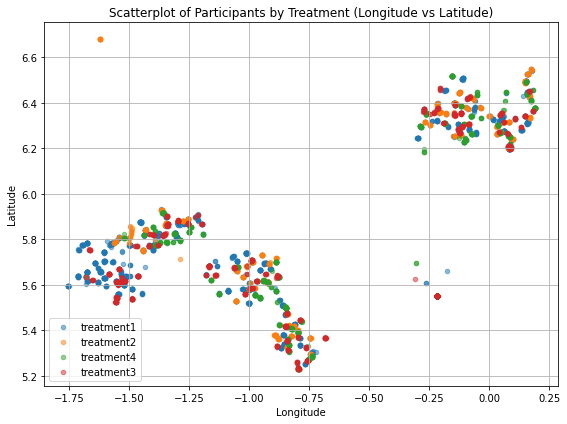

In [6]:
import matplotlib.pyplot as plt

subset = df.dropna(subset=['LocationLatitude', 'LocationLongitude', 'treatment'])

# scatterplot by treatment
plt.figure(figsize=(8,6))
for treatment in subset['treatment'].unique():
    group = subset[subset['treatment'] == treatment]
    plt.scatter(group['LocationLongitude'], group['LocationLatitude'], 
                label=treatment, alpha=0.5, s=20)

plt.title("Scatterplot of Participants by Treatment (Longitude vs Latitude)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("scatterplot_by_treatment.png")
plt.show()


For this assignment, we worked with a dataset from a field experiment on vaccine communication in Ghana. The goal was to recreate a spatial representation of the experiment and explore how treatments were assigned across districts.

We started by loading the dataset and selecting five variables: treatment group, district (from Q123), survey duration (Duration (in seconds)), and four numeric survey responses (E1, E2, E3, E5). The district information was extracted from the first two digits of Q123 and mapped to real district names using info from the lecture slides.

We cleaned the data by removing rows with missing values in the main variables and converting the survey responses to numeric values. This allowed us to calculate descriptive statistics. For example, the average survey duration was around 443 seconds, and the survey responses showed a wide range of values, likely reflecting different opinions or attitudes.

To show the spatial layout, we used folium to create an interactive map with clustered points. Each dot represented a participant, colored by treatment group, with popups showing their district. We also made separate maps for each treatment group to see how participants were spread out within each district.

For the scatterplot, we used latitude and longitude as 2D vectors to plot all participants. This gave a clear picture of how they were grouped geographically.

In summary, we were able to explore both the spatial distribution and some basic survey response data. The maps and statistics showed that treatments were well spread across districts and that the experiment seemed to be randomized as planned.